# Multilayer networks with Keras 


We will use a few functions from [`scikit-learn`](http://scikit-learn.org) to generate data sets:

In [1]:
from sklearn.datasets import make_blobs, make_circles, make_moons
from conv_net_utils import generate_dataset

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

We'll also set up some configuration variables up-front:

### The first example is a linearly separable data-set:

In [4]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_blobs, 
                                                                    n_train=1000, 
                                                                    n_test=200, 
                                                                    num_labels=2,
                                                                    centers=2, 
                                                                    center_box=[-4., 4.])

In [5]:
train_data.shape, train_labels.shape

((1000, 2), (1000, 2))

In [6]:
train_data[:10]

array([[ 4.680974  , -1.2464166 ],
       [ 1.5556324 , -1.2256787 ],
       [-0.613213  ,  1.481936  ],
       [ 4.6728597 , -1.5253456 ],
       [ 4.5501947 , -3.1164303 ],
       [-1.3322327 ,  0.76882607],
       [-2.3754337 , -0.85598165],
       [-1.3971653 ,  1.2555442 ],
       [ 3.5920684 , -0.9192761 ],
       [-1.006691  ,  0.9354626 ]], dtype=float32)

In [7]:
train_labels[:10]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

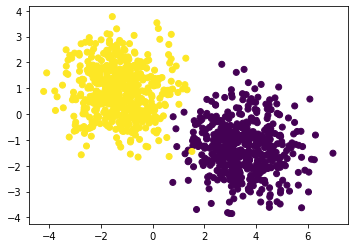

In [8]:
fig, ax = plt.subplots(1)
ax.scatter(train_data[:, 0], train_data[:, 1], c=np.where(train_labels)[1])
ax.set_aspect('equal')

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim

In [23]:
#GPU related settings
use_cuda = torch.cuda.is_available()
# use_cuda = True

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

print("USE CUDA=" + str (use_cuda))

USE CUDA=True


In [22]:
test_data = test_data.view(test_data.shape[0], -1)

In [7]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1000)

In [10]:
#from_numpy takes a numpy element and returns torch.tensor
train_data = torch.from_numpy(train_data).type(torch.FloatTensor)
train_labels = torch.from_numpy(train_labels).type(torch.LongTensor)

test_data = torch.from_numpy(test_data).type(torch.FloatTensor)
test_labels = torch.from_numpy(test_labels).type(torch.LongTensor)


In [ ]:
train_data = train_data.view(train_data.shape[0], -1)

In [ ]:
train_labels= np.argmax(train_labels,axis=1)

In [ ]:
test_data = test_data.view(test_data.shape[0], -1)

In [ ]:
test_labels= np.argmax(test_labels,axis=1)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
#our class must extend nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(2,32)
        
        #This applies linear transformation to produce output data
        self.fc2 = nn.Linear(32,2)
        
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x)
        #Activation function 
        x = F.relu(x)
        #This produces output
        x = self.fc2(x)
        return x
        
    #This function takes an input and predicts the class, (0 or 1)        
    def predict(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x))
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)
    

In [5]:
#Initialize the model        
model = Net()
#Define loss criterion
criterion = nn.CrossEntropyLoss()
#Define the optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001,  alpha = 0.9)

In [75]:
#Number of epochs
epochs = 5
#List to store losses
losses = []
for i in range(epochs):
    #Precit the output for Given input
    y_pred = model.forward(train_data)
    #Compute Cross entropy loss
    loss = criterion(y_pred,train_labels)
    #Add loss to the list
    losses.append(loss.item())
    #Clear the previous gradients
    optimizer.zero_grad()
    #Compute gradients
    loss.backward()
    #Adjust weights
    optimizer.step()
    running_loss = 0
    for data in trainloader:
        running_loss += loss.item()
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.7658113837242126
Training loss: 0.7052371501922607
Training loss: 0.6665639877319336
Training loss: 0.6368309259414673
Training loss: 0.6121678948402405


In [77]:
def accuracy(model, data_x, data_y):
  model = model.eval()  # NOTE

  X = torch.Tensor(data_x)
  Y = torch.LongTensor(data_y)
  oupt = model(X)
  (max_vals, arg_maxs) = torch.max(oupt.data, dim=1) 
  # arg_maxs is tensor of indices [0, 1, 0, 2, 1, 1 . . ]
  num_correct = torch.sum(Y==arg_maxs)
  acc = (num_correct * 100.0 / len(data_x))

  model = model.train()  # NOTE
  return acc.item( )  # percentage format


In [78]:
accuracy(model, test_data, test_labels)

52.5

## An aside about the softmax function 

The softmax function defined mathemtatically as: 

$f(y_i) = \frac{e^{y_i}}{\sum_i{e^{y_i}}}$

assigns each of the possible outputs a probability (a number between 0-1, all sum together to 1). 

It also has the effect of 'mutual inhibition' between alternative options. 

Consider our case, with two options:


In [85]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [86]:
output = []
xs = np.arange(1, 11, 1)
for ii in xs:
    x = [10-ii, ii]
    output.append(softmax(x))

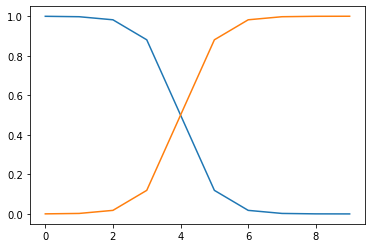

In [87]:
plt.plot(output)

In [83]:
prediction = np.round(model.predict(test_data)).squeeze()

/home/meltoscan/glotorch/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [84]:
prediction

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
def pred_func(x):
 #Convert into numpy element to tensor
 x = torch.from_numpy(x).type(torch.FloatTensor)
 #Predict and return answer
 ans = model.predict(x)
 return ans.numpy()

In [47]:
# function to plot a decision boundary.
def plot_decision_boundary(pred_func,X,y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)


/home/meltoscan/glotorch/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


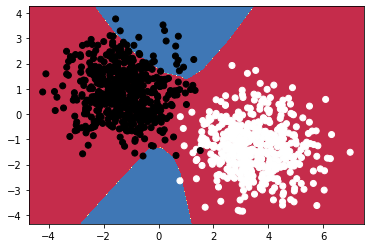

In [82]:
plot_decision_boundary(lambda x : pred_func(x) ,train_data.numpy(), train_labels.numpy())

### The next set of data is not linearly separable:

In [6]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_moons, 
                                                                    n_train=1000, 
                                                                    n_test=200,
                                                                    num_labels=2, 
                                                                    noise=0.2)

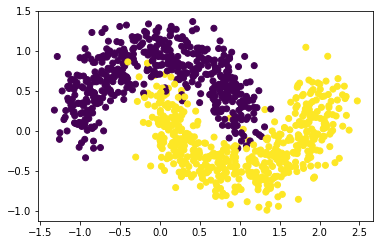

In [5]:
fig, ax = plt.subplots(1)
ax.scatter(train_data[:, 0], train_data[:, 1], c=np.where(train_labels)[1])
ax.set_aspect('equal')

In [8]:
train_data = train_data.view(train_data.shape[0], -1)
test_data = test_data.view(test_data.shape[0], -1)

In [7]:
train_data = torch.from_numpy(train_data).type(torch.FloatTensor)
train_labels = torch.from_numpy(train_labels).type(torch.LongTensor)

test_data = torch.from_numpy(test_data).type(torch.FloatTensor)
test_labels = torch.from_numpy(test_labels).type(torch.LongTensor)

In [10]:
train_labels= np.argmax(train_labels,axis=1)

In [16]:
test_labels= np.argmax(test_labels,axis=1)

In [12]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1000)

In [13]:
#### Number of epochs
epochs = 5
#List to store losses
losses = []
for i in range(epochs):
    #Precit the output for Given input
    y_pred = model.forward(train_data)
    #Compute Cross entropy loss
    loss = criterion(y_pred,train_labels)
    #Add loss to the list
    losses.append(loss.item())
    #Clear the previous gradients
    optimizer.zero_grad()
    #Compute gradients
    loss.backward()
    #Adjust weights
    optimizer.step()
    running_loss = 0
    for data in trainloader:
        running_loss += loss.item()
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.6384387016296387
Training loss: 0.6296768188476562
Training loss: 0.6224653720855713
Training loss: 0.6161589622497559
Training loss: 0.6104505062103271


In [40]:
def accuracy(model, data_x, data_y):
  model = model.eval()  

  X = torch.Tensor(data_x)
  Y = torch.LongTensor(data_y)
  oupt = model(X)
  (max_vals, arg_maxs) = torch.max(oupt.data, dim=1) 
  
  num_correct = torch.sum(Y==arg_maxs)
  acc = (num_correct * 100.0 / len(data_x))

  model = model.train()  
  return acc.item( )  # percentage format

In [17]:
accuracy(model, test_data, test_labels)

63.5

In [18]:
prediction = np.round(model.predict(test_data)).squeeze()

/home/meltoscan/glotorch/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [19]:
prediction

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

/home/meltoscan/glotorch/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


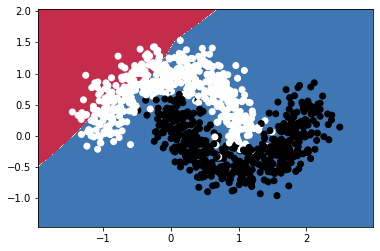

In [22]:
plot_decision_boundary(lambda x : pred_func(x) ,train_data.numpy(), train_labels.numpy())

In [6]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_circles, 
                                                                    n_train=1000,
                                                                    n_test=200, 
                                                                    noise=0.2, 
                                                                    num_labels=2,
                                                                    factor=0.1)

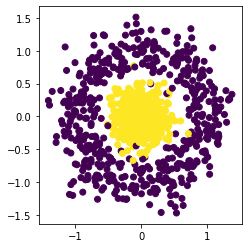

In [7]:
fig, ax = plt.subplots(1)
ax.scatter(train_data[:, 0], train_data[:, 1], c=np.where(train_labels)[1])
ax.set_aspect('equal')

In [8]:
train_data = torch.from_numpy(train_data).type(torch.FloatTensor)
train_labels = torch.from_numpy(train_labels).type(torch.LongTensor)

test_data = torch.from_numpy(test_data).type(torch.FloatTensor)
test_labels = torch.from_numpy(test_labels).type(torch.LongTensor)

In [9]:
train_data = train_data.view(train_data.shape[0], -1)
test_data = test_data.view(test_data.shape[0], -1)

In [10]:
train_labels= np.argmax(train_labels,axis=1)

In [11]:
test_labels= np.argmax(test_labels,axis=1)

In [13]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1000)

In [26]:
#### Number of epochs
epochs = 5
#List to store losses
losses = []
for i in range(epochs):
    #Precit the output for Given input
    y_pred = model.forward(train_data)
    #Compute Cross entropy loss
    loss = criterion(y_pred,train_labels)
    #Add loss to the list
    losses.append(loss.item())
   
    optimizer.zero_grad()
    #Compute gradients
    loss.backward()
    #Adjust weights
    optimizer.step()
    running_loss = 0
    for data in trainloader:
        running_loss += loss.item()
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.6638321280479431
Training loss: 0.6624782681465149
Training loss: 0.6611336469650269
Training loss: 0.659796953201294
Training loss: 0.6584663987159729


In [28]:
accuracy(model, test_data, test_labels)

79.5

/home/meltoscan/glotorch/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


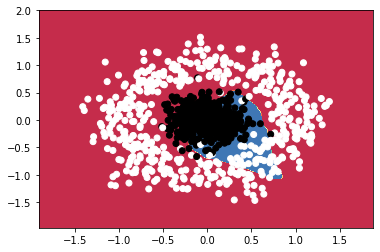

In [31]:
plot_decision_boundary(lambda x : pred_func(x) ,train_data.numpy(), train_labels.numpy())

In [37]:
#2 hidden layer net
import torch.nn as nn
import torch.nn.functional as F
#our class must extend nn.Module
class Net_big(nn.Module):
    def __init__(self):
        super(Net_big,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(2,32)
        self.fc2 = nn.Linear(32,32)
        #This applies linear transformation to produce output data
        self.fc3 = nn.Linear(32,2)
        
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x)
        #Activation function 
        x = F.relu(x)
        x = self.fc2(x)
        #Activation function 
        x = F.relu(x)
        #This produces output
        x = self.fc3(x)
        return x
        
    #This function takes an input and predicts the class, (0 or 1)        
    def predict(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x))
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [38]:
#Initialize the model        
model = Net_big()
#Define loss criterion
criterion = nn.CrossEntropyLoss()
#Define the optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001,  alpha = 0.9)

In [39]:
#Number of epochs
epochs = 5
#List to store losses
losses = []
for i in range(epochs):
    #Precit the output for Given input
    y_pred = model.forward(train_data)
    #Compute Cross entropy loss
    loss = criterion(y_pred,train_labels)
    #Add loss to the list
    losses.append(loss.item())
    #Clear the previous gradients
    optimizer.zero_grad()
    #Compute gradients
    loss.backward()
    #Adjust weights
    optimizer.step()
    running_loss = 0
    for data in trainloader:
        running_loss += loss.item()
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.6826781034469604
Training loss: 0.6761203408241272
Training loss: 0.6709024906158447
Training loss: 0.6662710905075073
Training loss: 0.6619689464569092


In [41]:
accuracy(model, test_data, test_labels)

93.5

In [43]:
prediction = np.round(model.predict(test_data)).squeeze()

/home/meltoscan/glotorch/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [45]:
prediction

tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0])

/home/meltoscan/glotorch/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


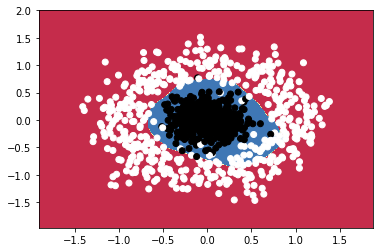

In [48]:
plot_decision_boundary(lambda x : pred_func(x) ,train_data.numpy(), train_labels.numpy())